In [ ]:
!pip install torch-scatter
!pip install torch-sparse
!pip install torch-geometric

  Created wheel for torch-scatter: filename=torch_scatter-2.0.9-cp37-cp37m-linux_x86_64.whl size=282114 sha256=36e3baecd038323fc309e9f5a0956e9cd8422bb798d569253087426199f00d5e
  Stored in directory: /root/.cache/pip/wheels/dd/57/a3/42ea193b77378ce634eb9454c9bc1e3163f3b482a35cdee4d1
Successfully built torch-scatter
     |████████████████████████████████| 43 kB 1.4 MB/s 
  Created wheel for torch-sparse: filename=torch_sparse-0.6.12-cp37-cp37m-linux_x86_64.whl size=505740 sha256=28573b4be22bf632d195005012998f470321d158505ec721fb098c898c9fbd8d
  Stored in directory: /root/.cache/pip/wheels/fb/e2/2f/44956c61e3299573ffe12da9d1374c7576ca0c5fb1fe1ed38c
Successfully built torch-sparse
     |████████████████████████████████| 325 kB 29.2 MB/s 
     |████████████████████████████████| 407 kB 58.4 MB/s 
     |████████████████████████████████| 45 kB 3.0 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.2-py3-none-any.whl size=535570 sha256=a7c3f8490b675ac7d684cbf61e69495d3ea963

In [ ]:
import numpy as np
import os
import copy

import torch
import torch_geometric as geo
from torch.autograd import Variable, grad
import torch.utils.data as Data
import matplotlib.pyplot as plt
from torch.autograd.functional import jacobian, hessian

Load database:

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
# change directory from your top level google drive to the RL folder (make sure step 1 is already done!)
%cd /gdrive/My\ Drive/MMLDT_graduate_short_course/Instructor_Steve_Sun_Jupyter_notebook/Lab3C_Geometric_learning_for_hyperelasticity_pyTorch/

/gdrive/.shortcut-targets-by-id/1rPDbVGz2lJwbzwXYyEpJn2BszNcSZhBU/MMLDT_graduate_short_course/Instructor_Steve_Sun_Jupyter_notebook/Lab3C_Geometric_learning_for_hyperelasticity_pyTorch


In [ ]:
# name of polycrystal features
items = ['vol','neighnb','area','diameq','sphericity','dihangleav','facenb','euler_1','euler_2','euler_3']
n_features = len(items)
# placeholders for graph data
gnn_data_list = []
gnn_feature_list = []

os.chdir('graph_process/database/tesselations/RVE_1')
for k in range(1,151):
    working_dir = '../RVE_'+str(k)+'/'
    os.chdir(working_dir)
    
    # load graph connectivity from the stored adjacency matrix
    A = np.load('A.npy').astype(np.int32)
    n_nodes = A.shape[0]
    n_edges = A.sum() // 2
    edge_index = np.zeros((2,n_edges), dtype=np.int32)
    # write to edge_list
    cnt = 0
    for i in range(n_nodes):
        for j in range(i, n_nodes):
            if A[i,j] > 0:
                edge_index[0,cnt] = i
                edge_index[1,cnt] = j
                cnt += 1
    
    # load crystal data from txt file
    X = np.zeros((n_nodes,n_features), dtype=np.double)
    for i in range(n_features):
        X[:,i] = np.loadtxt('poly/' + items[i] + '.txt')
    
    gnn_feature_list.append( torch.tensor(X, dtype=torch.double) )
    gnn_data_list.append( geo.data.Data(torch.tensor(X, dtype=torch.double), torch.tensor(edge_index,dtype=torch.long), torch.tensor([k-1])) )


In [ ]:
"""
    for large deformation cases
    convert F, P to C, S
"""
def convert_Defgrad_and_PKStress( dF_ , P_ ):
    # F = dF + I
    n_samples = dF_.shape[0]
    F_ = dF_.reshape(n_samples, 3,3)
    P_ = P_.reshape(n_samples, 3,3)
    C_ = np.zeros_like(F_)
    S_ = np.zeros_like(C_)
    for i in range(n_samples):
        F_[i,:,:] += np.eye(3)
        Fi = F_[i,:,:]
        C_[i,:,:] = Fi.transpose() @ Fi
        S_[i,:,:] = np.linalg.inv(Fi) @ P_[i,:,:]
    C_ = C_.reshape(n_samples, 9)
    S_ = S_.reshape(n_samples, 9)
    return C_, S_

# placeholders for energy data
energy_data_list = []
stretch_data_list = []
PKStress_data_list = []

os.chdir('../../../../elasticity/RVE_1')
for k in range(1,151):
    working_dir = '../RVE_'+str(k)+'/'
    os.chdir(working_dir)
    
    psi = np.load('psi.npy')
    # the input from 'deformation_gradient.npy' is actually F - I
    dF_ = np.load('deformation_gradient.npy')
    P_ = np.load('PKstress.npy')
    
    # compute C = F^T * F and S = F^-1 * P
    C_, S_ = convert_Defgrad_and_PKStress( dF_ , P_ )
    # because S = 2* d\psi / dC
    # we should use 0.5*S as the supervision on gradients
    S_ /= 2.
    energy_data_list.append(psi)
    stretch_data_list.append(C_)
    PKStress_data_list.append(S_)
os.chdir('../..')

Standardization:

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# scalers for normalization
gnn_data_scaler = StandardScaler()
energy_data_scaler   = StandardScaler()
stretch_data_scaler  = StandardScaler()
PKStress_data_scaler = StandardScaler()
PKStress_scaler_alt = MinMaxScaler()
gnn_data_scaler.fit(torch.cat(gnn_feature_list,dim=0).numpy().reshape(-1,n_features))
energy_data_scaler.fit  (np.concatenate(energy_data_list  , axis=0).reshape(-1,1))
stretch_data_scaler.fit (np.concatenate(stretch_data_list , axis=0).reshape(-1,9))
PKStress_data_scaler.fit(np.concatenate(PKStress_data_list, axis=0).reshape(-1,9))
# alternative min max scaler to check the validation acc
PKStress_scaler_alt.fit(np.concatenate(PKStress_data_list, axis=0).reshape(-1,9))

for k in range(150):
    # normalize GNN nodal features and energy model data
    tmp_gnn_features = gnn_data_scaler.transform(gnn_data_list[k].x)
    gnn_data_list[k].x = torch.tensor(tmp_gnn_features, dtype=torch.double) #####
    energy_data_list[k]   = energy_data_scaler  .transform(energy_data_list[k])
    energy_data_list[k]   = torch.tensor(energy_data_list[k], dtype=torch.double) #####
    stretch_data_list[k]  = stretch_data_scaler .transform(stretch_data_list[k])
    stretch_data_list[k]  = torch.tensor(stretch_data_list[k], dtype=torch.double) #####
    PKStress_data_list[k] = PKStress_data_scaler.transform(PKStress_data_list[k])
    PKStress_data_list[k] = torch.tensor(PKStress_data_list[k])

In [ ]:
# collect train_X, train_Y for each gnn batch
energy_scale  = torch.tensor(1. / energy_data_scaler.scale_, dtype=torch.double)
strain_scales = torch.tensor(stretch_data_scaler.scale_, dtype=torch.double)
stress_scales = torch.tensor(PKStress_data_scaler.scale_, dtype=torch.double)
stress_limits = torch.tensor(PKStress_data_scaler.mean_, dtype=torch.double)
data_scales = (strain_scales, energy_scale, stress_scales, stress_limits)
trainX_list = []
trainY_list = []
for bch in range(10):
    masks = [torch.full( (stretch_data_list[15*bch+m]. shape[0], 1), m, dtype=torch.int32 ) for m in range(15)]
    train_X = torch.stack(stretch_data_list[15*bch : 15*(bch+1)]).reshape((-1,9))
    train_X = torch.cat( (train_X, torch.stack(masks).reshape(-1,1)), axis=1 )
    trainX_list.append(Variable(train_X))
    train_Y = torch.cat( (torch.stack(energy_data_list[15*bch : 15*(bch+1)]).reshape(-1,1),\
        torch.stack(PKStress_data_list[15*bch : 15*(bch+1)]).reshape(-1,9) ), axis=1)
    trainY_list.append(Variable(train_Y))

# config parameters
BATCH_SIZE = 64
EPOCH = 160
MODEL_PATH = 'gnn_elas.pt'

# construct the dataloaders
train_loaders = []
valid_loaders = []
valid_split = .2
gnn_loaders = []
for bch in range(10):
    gnn_loaders.append( geo.data.DataLoader(gnn_data_list[15*bch : 15*(bch+1)], batch_size=15) )
    dataset_len = trainX_list[bch].shape[0]
    indices = list(range(dataset_len))
    # Randomly splitting indices:
    valid_idx = np.random.choice(indices, size=int(np.floor(valid_split * dataset_len)), replace=False)
    train_idx = list(set(indices) - set(valid_idx))
    # Defining the samplers for each phase based on the random indices:
    train_sampler = Data.SubsetRandomSampler(train_idx)
    valid_sampler = Data.SubsetRandomSampler(valid_idx)

    torch_dataset = Data.TensorDataset(trainX_list[bch], trainY_list[bch])
    train_loader = Data.DataLoader(torch_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
    valid_loader = Data.DataLoader(torch_dataset, batch_size=BATCH_SIZE, sampler=valid_sampler)
    train_loaders.append(train_loader)
    valid_loaders.append(valid_loader)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
import torch
from torch.autograd import Variable, grad
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F_
from torch.nn.init import xavier_uniform_
import numpy as np, copy
loss_func = nn.MSELoss()
DEBUG = False

class Multiply(nn.Module):

    def __init__(self):
        super(Multiply, self).__init__()

    def forward(self, inp_list):
        result = torch.ones(inp_list[0].size(), dtype=torch.double)
        for x in inp_list:
            result *= x

        return result


import torch_geometric as torchG
from torch_geometric.nn import GCNConv, global_mean_pool, GATv2Conv

In [ ]:
class GNN(nn.Module):

    def __init__(self, inp, out, hidden):
        super(GNN, self).__init__()
        self.conv1 = GATv2Conv(inp, hidden)
        self.conv2 = GATv2Conv(hidden, hidden)
        self.conv3 = GATv2Conv(hidden, hidden)
        self.conv4 = GATv2Conv(hidden, hidden)
        self.conv5 = GATv2Conv(hidden, hidden)
        self.bn1 = nn.BatchNorm1d(hidden)
        self.bn3 = nn.BatchNorm1d(hidden)
        self.bn4 = nn.BatchNorm1d(hidden)
        self.drop1 = nn.Dropout(p=0.5)
        self.lin1 = nn.Linear(hidden, (hidden // 2), bias=True)
        self.bn2 = nn.BatchNorm1d(hidden // 2)
        self.drop2 = nn.Dropout(p=0.5)
        xavier_uniform_(self.lin1.weight)
        self.lin2 = nn.Linear((hidden // 2), out, bias=True)
        self.bn3 = nn.BatchNorm1d(out)
        xavier_uniform_(self.lin2.weight)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F_.relu(x)
        x = self.drop1(x)
        x = self.conv2(x, edge_index)
        x = F_.relu(x)
        #x = self.bn3(x)
        x = self.conv3(x, edge_index)
        x = F_.relu(x)
        x = self.conv4(x, edge_index)
        x = F_.relu(x)
        #x = self.bn4(x)
        x = self.conv5(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.lin1(x)
        x = self.bn2(x)
        x = F_.relu(x)
        x = self.drop2(x)
        x = self.lin2(x)
        x = self.bn3(x)
        return x


class MixGNN(nn.Module):

    def __init__(self, inp, out, hidden, gnn_inp, gnn_out, gnn_hidden):
        super(MixGNN, self).__init__()
        self.gnn = GNN(gnn_inp, gnn_out, gnn_hidden)
        self.fc1 = nn.Linear((inp + gnn_out), hidden, bias=True)
        self.bn4 = nn.BatchNorm1d(hidden)
        self.drop4 = nn.Dropout(p=0.5)
        xavier_uniform_(self.fc1.weight)
        self.mult1 = Multiply()
        self.fc2 = nn.Linear(hidden, (hidden // 4), bias=True)
        self.bn5 = nn.BatchNorm1d(hidden // 4)
        self.drop5 = nn.Dropout(p=0.3)
        xavier_uniform_(self.fc2.weight)
        self.mult2 = Multiply()
        self.mult3 = Multiply()
        self.fc3 = nn.Linear((hidden // 4), out, bias=True)

    def forward(self, x, masks, gnn_x, edge_index, gnn_batch, debug=False):
        gnn_x = self.gnn(gnn_x, edge_index, gnn_batch)
        gnn_x = gnn_x[masks, :]
        h = torch.cat((x, gnn_x), axis=1)
        h = self.fc1(h)
        h = self.bn4(h)
        h = F_.relu(h)
        h = self.mult1([h, h])
        h = self.drop4(h)
        h = self.fc2(h)
        h = self.bn5(h)
        h = F_.relu(h)
        h = self.mult2([h, h])
        h = self.mult3([h, h])
        h = self.drop5(h)
        h = self.fc3(h)
        return h

    def predict_energy(self, x, masks, gnn_x, edge_index, gnn_batch, data_scales):
        in_scales, out_scale, grad_scales, grad_limits = data_scales
        y = self(x, masks, gnn_x, edge_index, gnn_batch)
        grad_y, = grad((y.sum()), x, create_graph=True)
        grad_y /= torch.tensor(in_scales) * out_scale
        grad_y -= torch.tensor(grad_limits)
        grad_y /= torch.tensor(grad_scales)
        return (x.detach().numpy(), y.detach().numpy(), grad_y.detach().numpy())

In [ ]:

def train_H1_scaled_hybrid(net, train_loaders, valid_loaders, graph_loaders, EPOCH, BATCH_SIZE, optimizer, scheduler, data_scales, lam1):
    best_loss = np.inf
    num_train_data = np.array([len(train_loader.dataset) for train_loader in train_loaders], dtype=(np.int32)).sum()
    num_valid_data = np.array([len(val_loader.dataset) for val_loader in valid_loaders], dtype=(np.int32)).sum()
    in_scales, out_scale, grad_scales, grad_limits = data_scales
    lossTotal = np.zeros((EPOCH, 1))
    lossVal = np.zeros((EPOCH, 1))
    lossGrad = np.zeros((EPOCH, 1))
    vlossTotal = np.zeros((EPOCH, 1))
    vlossVal = np.zeros((EPOCH, 1))
    vlossGrad = np.zeros((EPOCH, 1))
    terminate_training = False
    eps = 1e-06
    for epoch in range(EPOCH):
        epoch_mse0 = 0.0
        epoch_mse1 = 0.0
        epoch_val_mse0 = 0.0
        epoch_val_mse1 = 0.0
        for bch in range(len(train_loaders)):
            train_loader = train_loaders[bch]
            valid_loader = valid_loaders[bch]
            graph_loader = graph_loaders[bch]
            num_gnn_batch = 0
            for _, temp_data in enumerate(graph_loader):
                num_gnn_batch += 1

            assert num_gnn_batch == 1
            gnn_data = copy.deepcopy(temp_data)
            for cnt, (batch_x, batch_y) in enumerate(train_loader):
                b_x = Variable((batch_x[:, :-1]), requires_grad=True)
                b_y = Variable(batch_y)
                masks = batch_x[:, -1].long()
                net.eval()

                output0 = net(b_x, masks, (gnn_data.x), (gnn_data.edge_index), (gnn_data.batch), debug=DEBUG)
                output1, = grad((output0.sum()), b_x, create_graph=True)
                b_x.requires_grad = False
                output1 /= torch.tensor(in_scales) * out_scale
                output1 -= torch.tensor(grad_limits)
                output1 /= torch.tensor(grad_scales)
                net.train()
                mse0 = loss_func(output0, b_y[:, 0:1])
                mse1 = loss_func(output1, b_y[:, 1:])
                epoch_mse0 += mse0.detach().item() * BATCH_SIZE
                epoch_mse1 += mse1.detach().item() * BATCH_SIZE
                loss = mse0 + lam1 * mse1
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            for _, (batch_x, batch_y) in enumerate(valid_loader):
                b_x = Variable((batch_x[:, :-1]), requires_grad=True)
                b_y = Variable(batch_y)
                masks = batch_x[:, -1].long()
                num_gnn_batch = 0
                for _, temp_data in enumerate(graph_loader):
                    num_gnn_batch += 1

                assert num_gnn_batch == 1
                gnn_data = copy.deepcopy(temp_data)
                net.eval()
                output0 = net(b_x, masks, gnn_data.x, gnn_data.edge_index, gnn_data.batch)
                output1, = grad((output0.sum()), b_x, create_graph=True)
                b_x.requires_grad = False
                output1 /= torch.tensor(in_scales) * out_scale
                output1 -= torch.tensor(grad_limits)
                output1 /= torch.tensor(grad_scales)
                epoch_val_mse0 += loss_func(output0, b_y[:, 0:1]).detach().item() * BATCH_SIZE
                epoch_val_mse1 += loss_func(output1, b_y[:, 1:]).detach().item() * BATCH_SIZE

        epoch_mse0 /= num_train_data
        epoch_mse1 /= num_train_data
        epoch_loss = epoch_mse0 + lam1 * epoch_mse1
        epoch_val_mse0 /= num_valid_data
        epoch_val_mse1 /= num_valid_data
        epoch_val_loss = epoch_val_mse0 + lam1 * epoch_val_mse1
        scheduler.step()
        lossTotal[epoch] = epoch_loss
        lossVal[epoch] = epoch_mse0
        lossGrad[epoch] = epoch_mse1
        vlossTotal[epoch] = epoch_val_loss
        vlossVal[epoch] = epoch_val_mse0
        vlossGrad[epoch] = epoch_val_mse1
        if  (epoch) % 5 == 0:
            print('    epoch {:4d}'.format(epoch + 1), 'lr: {:.7f}'.format(optimizer.param_groups[0]['lr']), 'train val loss: {:.3e}'.format(epoch_mse0), 'train grad loss: {:.3e}'.format(epoch_mse1), 'train total loss: {:.3e}'.format(epoch_loss), 'valid val loss: {:.3e}'.format(epoch_val_mse0), 'valid grad loss: {:.3e}'.format(epoch_val_mse1), 'valid total loss: {:.3e}'.format(epoch_val_loss))
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                state = copy.deepcopy(net.state_dict())

    print('Best score:', best_loss)
    return (state, lossTotal, lossVal, lossGrad, vlossTotal, vlossVal, vlossGrad)

In [ ]:
net = MixGNN(inp=9, out=1, hidden=256, gnn_inp=n_features, gnn_out=9, gnn_hidden=64).double()
optimizer = torch.optim.Adam(net.parameters(), lr=2e-3, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.7)
# reserve the last 15 RVEs for test purpose

#torch.save(state_energy, MODEL_PATH)

In [ ]:
state_energy, lossTotal, lossVal, lossGrad, vlossTotal, vlossVal, vlossGrad =\
train_H1_scaled_hybrid(net.double(), train_loaders, valid_loaders, gnn_loaders, EPOCH, BATCH_SIZE, optimizer, scheduler, data_scales, lam1=.5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

    epoch    1 lr: 0.0020000 train val loss: 8.199e-03 train grad loss: 4.045e-02 train total loss: 2.843e-02 valid val loss: 3.958e-04 valid grad loss: 4.339e-03 valid total loss: 2.565e-03
    epoch    6 lr: 0.0020000 train val loss: 8.499e-03 train grad loss: 4.028e-02 train total loss: 2.864e-02 valid val loss: 4.211e-04 valid grad loss: 4.035e-03 valid total loss: 2.438e-03
    epoch   11 lr: 0.0014000 train val loss: 4.599e-03 train grad loss: 2.343e-02 train total loss: 1.631e-02 valid val loss: 2.551e-04 valid grad loss: 2.680e-03 valid total loss: 1.595e-03
    epoch   16 lr: 0.0014000 train val loss: 2.710e-03 train grad loss: 1.526e-02 train total loss: 1.034e-02 valid val loss: 1.417e-04 valid grad loss: 1.919e-03 valid total loss: 1.101e-03
    epoch   21 lr: 0.0014000 train val loss: 2.337e-03 train grad loss: 1.308e-02 train total loss: 8.879e-03 valid val loss: 1.039e-04 valid grad loss: 1.521e-03 valid total loss: 8.644e-04
    epoch   26 lr: 0.0014000 train val loss: 

In [ ]:
# test graph data from gnn_loader[0]
num_gnn_batch = 0
for _, temp_data in enumerate(gnn_loaders[1]):
    num_gnn_batch += 1
assert(num_gnn_batch == 1)
gnn_data = copy.deepcopy(temp_data)


# prepare test X
test_X = Variable(trainX_list[1][:,:-1], requires_grad = True)
test_masks = trainX_list[1][:,-1].long()

test_true_strain = stretch_data_scaler.inverse_transform( test_X.detach().numpy() )
test_true_energy = energy_data_scaler.inverse_transform( trainY_list[1][:,0:1].detach().numpy() )
test_true_stress = PKStress_data_scaler.inverse_transform( trainY_list[1][:,1:].detach().numpy() )

# test routine
net.load_state_dict(state_energy)
net.eval()
test_Y = net(test_X, test_masks, gnn_data.x, gnn_data.edge_index, gnn_data.batch)
test_YGrad, = grad(test_Y.sum(), test_X, create_graph=True)
test_YGrad /= (torch.tensor(strain_scales) * energy_scale)
test_pred_stress = test_YGrad.detach().numpy()

from sklearn.metrics import mean_squared_error
test_loss = mean_squared_error( PKStress_data_scaler.transform(test_pred_stress),\
    PKStress_data_scaler.transform(test_true_stress) )
print('test MSE: ', test_loss)

test MSE:  0.005979488086594809


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


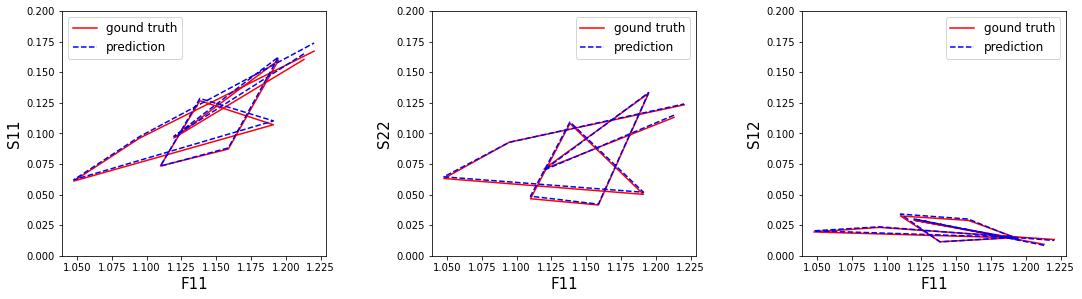

In [ ]:
test_plot_range = range(0,10)
strain_hist = test_true_strain[test_plot_range,:]
stress_hist_true = test_true_stress[test_plot_range,:]
stress_hist_pred = test_pred_stress[test_plot_range,:]

fig, axs = plt.subplots(1, 3, figsize=(18,4.5),\
        gridspec_kw={'wspace': 0.4, 'hspace': 0.2})
ax = axs[0]
ax.plot(strain_hist[:,0], stress_hist_true[:,0], 'r-', label='gound truth')
ax.plot(strain_hist[:,0], stress_hist_pred[:,0], 'b--', label='prediction')
ax.set_xlabel("F11", fontsize=15)
ax.set_ylabel("S11", fontsize=15)
ax.set_ylim([0,0.2])
ax.legend(fontsize=12)

ax = axs[1]
ax.plot(strain_hist[:,0], stress_hist_true[:,4], 'r-', label='gound truth')
ax.plot(strain_hist[:,0], stress_hist_pred[:,4], 'b--', label='prediction')
ax.set_xlabel("F11", fontsize=15)
ax.set_ylabel("S22", fontsize=15)
ax.set_ylim([0,0.2])
ax.legend(fontsize=12)

ax = axs[2]
ax.plot(strain_hist[:,0], stress_hist_true[:,1], 'r-', label='gound truth')
ax.plot(strain_hist[:,0], stress_hist_pred[:,1], 'b--', label='prediction')
ax.set_xlabel("F11", fontsize=15)
ax.set_ylabel("S12", fontsize=15)
ax.set_ylim([0,0.2])
ax.legend(fontsize=12)